In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten

np.random.seed(1989)

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

image_size = X_train.shape[1]
X_train = (np.reshape(X_train, [-1, image_size, image_size, 1]).astype('float32')) / 255
X_test = (np.reshape(X_test, [-1, image_size, image_size, 1]).astype('float32')) / 255

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# Generating Corrupted MNIST

noise = np.random.normal(loc = 0.5, scale=0.5, size = X_train.shape)
X_train_noisy = X_train + noise

noise = np.random.normal(loc = 0.5, scale=0.5, size = X_test.shape)
X_test_noise = X_test + noise

In [4]:
# Normalizing pixel values

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noise = np.clip(X_test_noise, 0., 1.)

In [5]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

In [6]:
# Encoder

inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layer_filters:
  x = Conv2D(filters = filters, kernel_size = kernel_size,
             strides = 2, activation = 'relu', padding = 'same')(x)
  
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)
encoder = Model(inputs, latent, name = 'encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Decoder

latent_inputs = Input(shape = (latent_dim, ), name = 'decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size,
                      strides = 2, activation = 'relu', padding = 'same')(x)

outputs = Conv2DTranspose(filters = 1, kernel_size = kernel_size,
                          padding = 'same', activation = 'sigmoid',
                          name = 'decoder_output')(x)

decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [9]:
# Autoencoder

autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.compile(loss = 'mse', optimizer = 'adam')
autoencoder.fit(X_train_noisy, X_train,
                validation_data = (X_test_noise, X_test),
                epochs = 10,
                batch_size = batch_size)

Epoch 1/10
1875/1875 [==============================] - 39s 4ms/step - loss: 0.0360 - val_loss: 0.0201
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0192 - val_loss: 0.0179
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0169 - val_loss: 0.0166
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.01

In [11]:
X_decoded = autoencoder.predict(X_test_noise)

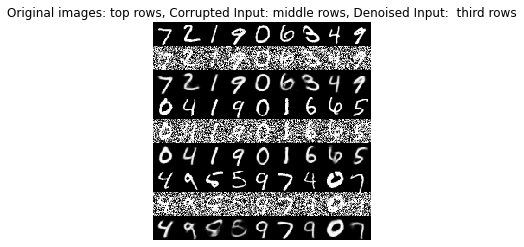

In [13]:
rows, cols = 3, 9
num = rows * cols

imgs = np.concatenate([X_test[:num], X_test_noise[:num], X_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()